In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import auc, roc_curve, roc_auc_score,  classification_report, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix
from helper_functions import *
from pipeline import *

In [2]:
X = pipeline('../data/stratified_train.csv', drop_cat=False)
y = X.pop('Target')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [3]:
X_train.head()

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Avg Air Temp (F),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),...,Victorville,Watsonville West II,West Hills,Westlands,Westmorland North,Williams,Winchester,Windsor,Winters,Woodland
108251,-0.681431,-0.182050,-0.700042,0.294379,-0.025734,0.355841,0.418763,-0.363972,-0.360071,0.057787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87906,-1.272365,-0.182050,-1.270230,0.456852,-0.200027,0.841554,0.561857,-0.642357,-0.646217,0.149416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66411,-1.022826,-0.182050,-1.028026,-1.167877,-1.222020,-0.129871,-1.199995,-1.059934,-1.052234,-1.371623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29237,-0.835906,-0.182050,-0.306462,-1.214297,-1.198253,-0.227014,-1.271542,-0.735152,-0.719686,-0.931804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109037,0.228955,-0.036919,-0.644537,0.712166,2.152933,-1.441294,0.749669,0.192797,0.183219,2.101110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


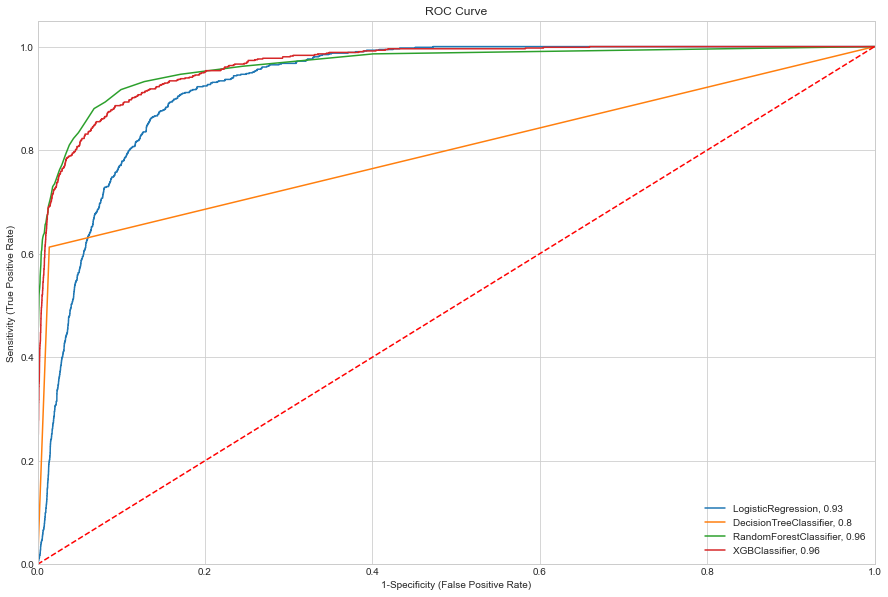

<Figure size 432x288 with 0 Axes>

In [6]:
classification_models = [LogisticRegression(class_weight='balanced', max_iter=10000, n_jobs=-1), DecisionTreeClassifier(), RandomForestClassifier(class_weight='balanced'), XGBClassifier()]
model_comparison(classification_models, X_train, y_train, X_test, y_test)
plt.savefig('../images/initial_comparison.png');

Accuracy is not a valid evaluation metric because of the class imbalance.

Which is worse: **FP** or **FN**?

*Reason shows a **FN** (like ignoring a fire alarm) is MUCH WORSE.*

$$Recall = \frac{TP}{TP + FN}$$

Therefore **Recall** is the best metric to evaluate the models by. Therefore out-of-box Random Forest outperforms XGB.

In [9]:
rf = RandomForestClassifier(class_weight='balanced')
rf_recall_scores = cross_val_score(rf, X_train, y_train,
                           scoring='recall', cv=5, n_jobs=-1)
print('RF OOB Recall', round(np.mean(rf_recall_scores),2))

rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
print('Out of box RF:')
print(classification_report(y_test, rf_y_pred))

RF OOB Recall 0.3686619718309859
Out of box RF:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22707
           1       0.97      0.44      0.60       710

    accuracy                           0.98     23417
   macro avg       0.98      0.72      0.80     23417
weighted avg       0.98      0.98      0.98     23417



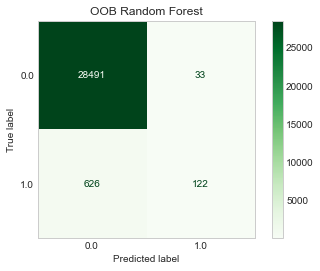

In [21]:
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Greens)
plt.title('OOB Random Forest')
plt.grid(False);

In [14]:
recall_score(y_test, rf_y_pred)

0.4394366197183099

In [10]:
xgb = XGBClassifier()
xgb_recall_scores = cross_val_score(xgb, X_train, y_train,
                           scoring='recall', cv=5, n_jobs=-1)
print('XGB OOB Recall', np.mean(xgb_recall_scores))

xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)
print('Out of box XGB:')
print(classification_report(y_test, xgb_y_pred))

XGB OOB Recall 0.3799295774647887
Out of box XGB:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22707
           1       0.83      0.41      0.55       710

    accuracy                           0.98     23417
   macro avg       0.90      0.70      0.77     23417
weighted avg       0.98      0.98      0.98     23417



In [25]:
plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Purples)
plt.title('Numerical & Categorical Features')
plt.grid(False);

ValueError: feature_names mismatch: ['ETo (in)', 'Precip (in)', 'Sol Rad (Ly/day)', 'Avg Vap Pres (mBars)', 'Avg Air Temp (F)', 'Avg Rel Hum (%)', 'Dew Point (F)', 'Avg Wind Speed (mph)', 'Wind Run (miles)', 'Avg Soil Temp (F)'] ['ETo (in)', 'Precip (in)', 'Sol Rad (Ly/day)', 'Avg Vap Pres (mBars)', 'Avg Air Temp (F)', 'Avg Rel Hum (%)', 'Dew Point (F)', 'Avg Wind Speed (mph)', 'Wind Run (miles)', 'Avg Soil Temp (F)', 'Alturas', 'Arleta', 'Arroyo Seco', 'Arvin-Edison', 'Atascadero', 'Auburn', 'Belridge', 'Bennett Valley', 'Big Bear Lake', 'Biggs', 'Bishop', 'Black Point', 'Blackwells Corner', 'Blythe NE', 'Borrego Springs', 'Brentwood', 'Browns Valley', 'Bryte (experimental)', 'Buntingville', 'Cadiz Valley', 'Calipatria/Mulberry', 'Camarillo', 'Camino', 'Carmel', 'Carneros', 'Chatsworth', 'Chino', 'Coalinga', 'Concord', 'Coto de Caza', 'Cuyama', 'Davis', 'De Laveaga', 'Delano', 'Denair II', 'Diamond Springs', 'Dixon', 'Durham', 'El Cerrito', 'Escondido SPV', 'Fair Oaks', 'Ferndale Plain', 'Firebaugh/Telles', 'FivePoints', 'Fresno State', 'Gazelle', 'Gerber South', 'Gilroy', 'Green Valley Road', 'Hastings Tract East', 'Hemet', 'Highland', 'Holt', 'Indio 2', 'Irvine', 'Jersey Island', 'Joshua Tree', 'Kesterson', 'King City-Oasis Rd.', 'La Quinta II', 'Laguna Seca', 'Lake Arrowhead', 'Lancaster', 'Lemon Cove', 'Lindcove', 'Linden', 'Lompoc', 'Long Beach', 'Los Banos', 'Macdoel II', 'Manteca', 'Markleeville', 'McArthur', 'Meloland', 'Merced', 'Miramar', 'Modesto', 'Monrovia', 'Montague', 'Moorpark', 'Moraga', 'Newberry Springs II', 'Nipomo', 'North Hollywood', 'Oakdale', 'Oakland Metro', 'Oakville', 'Oasis', 'Orange Cove', 'Otay Lake', 'Owens Lake North', 'Owens Lake South', 'Pacific Grove', 'Pajaro', 'Palmdale', 'Palmdale Central', 'Palo Verde II', 'Panoche', 'Parlier', 'Perris - Menifee', 'Pescadero', 'Petaluma East', 'Pleasanton', 'Plymouth', 'Point San Pedro', 'Pomona', 'Porterville', 'Ridgecrest', 'Ripley', 'Ripon', 'Ryde', 'Salinas North', 'Salinas South II', 'San Benito', 'San Clemente', 'San Diego II', 'San Juan Valley', 'San Luis Obispo', 'San Luis Obispo West', 'Sanel Valley', 'Santa Barbara', 'Santa Clarita', 'Santa Maria II', 'Santa Monica', 'Santa Paula', 'Santa Rosa', 'Santa Ynez', 'Scott Valley', 'Seeley', 'Shafter', 'Shasta College', 'Sisquoc', 'Soledad II', 'Staten Island', 'Stratford', 'Temecula', 'Temecula East III', 'Thermal South', 'Torrey Pines', 'Tulelake FS', 'Twitchell Island', 'U.C. Riverside', 'Union City', 'Verona', 'Victorville', 'Watsonville West II', 'West Hills', 'Westlands', 'Westmorland North', 'Williams', 'Winchester', 'Windsor', 'Winters', 'Woodland']
training data did not have the following fields: Long Beach, Salinas North, Bryte (experimental), FivePoints, Palmdale Central, Westlands, Palo Verde II, Pacific Grove, Linden, Winchester, Seeley, Diamond Springs, Ferndale Plain, Carmel, Brentwood, San Clemente, Soledad II, Sanel Valley, Ripley, Stratford, Calipatria/Mulberry, Auburn, Kesterson, Staten Island, Tulelake FS, Parlier, Coalinga, Torrey Pines, Laguna Seca, Shasta College, Otay Lake, Ridgecrest, Davis, Ripon, Indio 2, U.C. Riverside, Orange Cove, Delano, Pomona, Temecula, San Benito, Modesto, Cadiz Valley, Moorpark, North Hollywood, Salinas South II, San Juan Valley, Atascadero, Gilroy, Shafter, Concord, Black Point, Big Bear Lake, McArthur, Woodland, Gazelle, Scott Valley, Buntingville, San Diego II, Arvin-Edison, Plymouth, Monrovia, Biggs, Lindcove, Alturas, Oakdale, Joshua Tree, Lancaster, Jersey Island, Moraga, Arleta, Santa Barbara, Oakland Metro, Thermal South, Firebaugh/Telles, Arroyo Seco, Santa Clarita, Meloland, Santa Paula, Westmorland North, Camarillo, Irvine, King City-Oasis Rd., Hastings Tract East, San Luis Obispo, Denair II, Watsonville West II, Pleasanton, Escondido SPV, Pescadero, Winters, De Laveaga, Chino, Fair Oaks, Lompoc, Oakville, Pajaro, West Hills, Santa Maria II, Borrego Springs, Newberry Springs II, Perris - Menifee, Ryde, Santa Ynez, Blackwells Corner, Hemet, Green Valley Road, Cuyama, Bishop, Fresno State, Manteca, Lemon Cove, Sisquoc, Markleeville, Gerber South, Point San Pedro, Chatsworth, Durham, Victorville, Blythe NE, Santa Rosa, Williams, Santa Monica, Oasis, El Cerrito, Verona, Browns Valley, Carneros, Dixon, Highland, Union City, Montague, San Luis Obispo West, Twitchell Island, Panoche, Los Banos, Merced, Temecula East III, Miramar, Belridge, Bennett Valley, Palmdale, Lake Arrowhead, Macdoel II, Nipomo, Windsor, Coto de Caza, La Quinta II, Owens Lake South, Holt, Owens Lake North, Petaluma East, Camino, Porterville

In [16]:
recall_score(y_test, xgb_y_pred)

0.4070422535211268

*Both RF and XGB are overfitting to training data. XGB outperforms RF OOB very slightly with cross validation.*

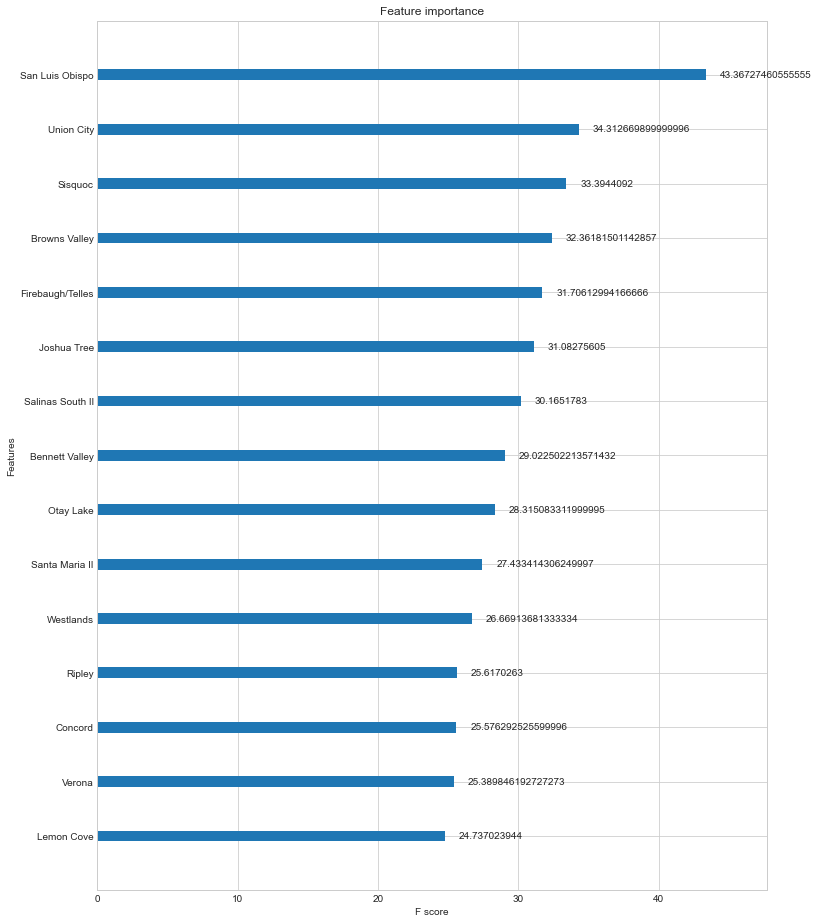

In [26]:
fig, ax = plt.subplots(figsize=(12,16))
plot_importance(xgb, ax=ax, max_num_features=15, importance_type='gain');

XGB's top 15 features to split on for maximum average gain. To better understand the tabular dataset, creating another data pipeline that removes the `Stn Id` column before one-hot encoding all stations.

In [2]:
X = pipeline('../data/stratified_train.csv')
y = X.pop('Target')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [3]:
xgb = XGBClassifier()
xgb_recall_scores = cross_val_score(xgb, X_train, y_train,
                           scoring='recall', cv=5, n_jobs=-1)
print('XGB OOB Recall', np.mean(xgb_recall_scores))

xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)
print('Out of box XGB:')
print(classification_report(y_test, xgb_y_pred))

XGB OOB Recall 0.13450704225352114
Out of box XGB:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     22707
           1       0.78      0.17      0.29       710

    accuracy                           0.97     23417
   macro avg       0.87      0.59      0.64     23417
weighted avg       0.97      0.97      0.97     23417



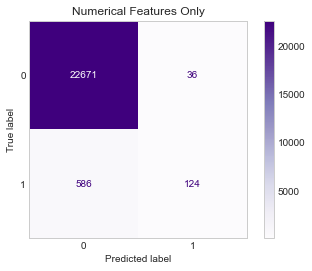

In [21]:
plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Purples)
plt.title('Numerical Features Only')
plt.grid(False);

In [5]:
recall_score(y_test, xgb_y_pred)

0.17464788732394365

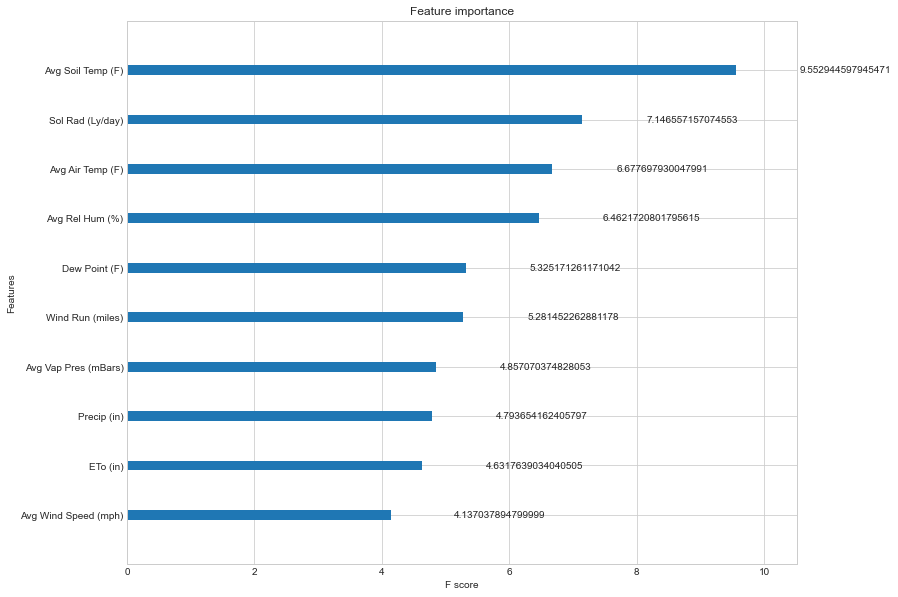

In [10]:
fig, ax = plt.subplots(figsize=(12,10))
plot_importance(xgb, ax=ax, importance_type='gain');

*XGB performs MUCH MUCH MUCH worse with only numerical features.*

In [16]:
exp_X_train = pd.DataFrame(X_train['Avg Soil Temp (F)']).copy()
exp_X_test = pd.DataFrame(X_test['Avg Soil Temp (F)']).copy()
clf = LogisticRegression()
clf.fit(exp_X_train, y_train)
clf_y_pred = clf.predict(exp_X_test)
recall_score(y_test, clf_y_pred)

0.0

In [17]:
clf.coef_

array([[0.8670423]])